## Regressão logística - Variáveis agregadas (2018 a 2024)

### Bibliotecas e bases de dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay

#Estilizar conteúdo
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

def estilo_tabelas(df, max_altura='300px', casas_decimais=3):
    def cor_linhas(row):
        if row.name % 2 == 0:
            return ['background-color: #ffffff'] * len(row)
        else:
            return ['background-color: #f9f9f9'] * len(row)
    
    return (
        df.style.apply(cor_linhas, axis=1) 
        .set_table_styles(
            [
                {'selector': 'thead th', 'props': [('font-size', '12px'), ('text-align', 'center'), ('border-bottom', '2px solid #007BFF')]},  # Azul abaixo do nome das colunas
                {'selector': 'td', 'props': [('font-size', '10px'), ('text-align', 'center'), ('max-height', '40px'), ('white-space', 'nowrap'), ('text-overflow', 'ellipsis'), ('overflow', 'hidden'), ('max-width', '300px')]},
                {'selector': 'table', 'props': [('width', '90%'), ('margin-left', 'auto'), ('margin-right', 'auto'), ('border-collapse', 'collapse')]},
                {'selector': 'td, th', 'props': [('border', '1px solid #666')]},
            ]
        )
        .set_properties(
            **{'border-color': 'darkgray', 'border-style': 'solid', 'border-width': '1px'}
        )
        .set_table_attributes(
            f'style="height:auto; overflow:auto; max-height:{max_altura}; display:block;"'  
        )
        .format(
            precision=casas_decimais  
        )
    )

In [2]:
df_eventos_2018_2024_modelo1 = pd.read_csv(
    "https://raw.githubusercontent.com/brunagmoura/PrevisorReconhecimento/refs/heads/main/df_eventos_2018_2024_modelo1.csv",
    sep=';',
    decimal=',',
)

### Ajustes da base de dados

In [3]:
df_eventos_2018_2024_modelo1 = df_eventos_2018_2024_modelo1.dropna()

estilo_tabelas(df_eventos_2018_2024_modelo1.head(5))

,Status,DH_total_danos_humanos,DM_total_danos_materiais,PEPL_total_publico,PEPR_total_privado,regiao_Centro-oeste,regiao_Nordeste,regiao_Norte,regiao_Sudeste,regiao_Sul,COBRADE_11110,COBRADE_11120,COBRADE_11311,COBRADE_11312,COBRADE_11313,COBRADE_11321,COBRADE_11331,COBRADE_11332,COBRADE_11340,COBRADE_11410,COBRADE_11420,COBRADE_11431,COBRADE_11432,COBRADE_11433,COBRADE_12100,COBRADE_12200,COBRADE_12300,COBRADE_13111,COBRADE_13112,COBRADE_13120,COBRADE_13211,COBRADE_13212,COBRADE_13213,COBRADE_13214,COBRADE_13215,COBRADE_13310,COBRADE_13321,COBRADE_13322,COBRADE_14110,COBRADE_14120,COBRADE_14131,COBRADE_14132,COBRADE_14140,COBRADE_15110,COBRADE_15120,COBRADE_15130,COBRADE_15210,COBRADE_15230,COBRADE_22210,COBRADE_22220,COBRADE_23120,COBRADE_24100,COBRADE_24200,COBRADE_25100,COBRADE_25500,DOMICILIO_AREARURAL,PDEFAGUA,PDEFESGOTO,PDEFLIXO,PDEFSAN,QTDE_FAMILIAS_ATUALIZADAS
0,0,11650,0.000,132466.926,861035.020,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.305,0.191,0.559,0.167,0.091,383.000
1,0,2548,0.000,103709.315,6509159.048,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.632,0.246,0.456,0.175,0.070,57.000
2,1,336,2296093.386,1928129.702,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.708,0.691,0.851,0.691,0.576,356.000
3,0,420,9811880.000,8974880.000,29950000.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.187,0.098,0.992,0.139,0.077,632.000
4,0,13245,0.000,286229.997,1353851.954,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.242,0.157,0.187,0.063,0.028,2231.000


### Treino e teste

In [4]:
X_2018_2024_modelo1 = df_eventos_2018_2024_modelo1.drop('Status', axis=1)

y_2018_2024_modelo1 = df_eventos_2018_2024_modelo1['Status']

X_train_2018_2024_modelo1, X_test_2018_2024_modelo1, y_train_2018_2024_modelo1, y_test_2018_2024_modelo1 = train_test_split(X_2018_2024_modelo1, y_2018_2024_modelo1, test_size=0.2, random_state=1, stratify=y_2018_2024_modelo1)

### Resultados - sem balanceamento

In [5]:
# Criar pipeline com normalização e modelo de Regressão Logística
pipeline_2018_2024_modelo1 = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(random_state=1, solver='lbfgs'))
])

# Definir hiperparâmetros para o Grid Search
param_grid_2018_2024_modelo1 = {
    'logreg__C': [0.01, 0.1, 1, 10],  # Regularização
    'logreg__max_iter': [1000],  # Número máximo de iterações
    'logreg__fit_intercept': [True, False],  # Se deve ajustar o intercepto
    'logreg__tol': [1e-4, 1e-3],  # Tolerância para convergência
    'logreg__penalty': ['l1', 'l2'],  # Tipos de penalidade
}

# Grid Search com validação cruzada
grid_search_2018_2024_modelo1 = GridSearchCV(pipeline_2018_2024_modelo1, param_grid_2018_2024_modelo1, cv=3, scoring='f1_weighted', n_jobs=-1)

grid_search_2018_2024_modelo1.fit(X_train_2018_2024_modelo1, y_train_2018_2024_modelo1)

# Melhor modelo encontrado
logreg_best_2018_2024_modelo1 = grid_search_2018_2024_modelo1.best_estimator_

print(f"Melhores hiperparâmetros: {grid_search_2018_2024_modelo1.best_params_}")

# F1 score no conjunto de teste
y_pred_2018_2024_modelo1 = logreg_best_2018_2024_modelo1.predict(X_test_2018_2024_modelo1)

f1_2018_2024_modelo1 = f1_score(y_test_2018_2024_modelo1, y_pred_2018_2024_modelo1, average='weighted')
print(f"F1 Score: {f1_2018_2024_modelo1:.6f}")

classification_report_2018_2024_modelo1 = metrics.classification_report(y_test_2018_2024_modelo1, y_pred_2018_2024_modelo1, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para modelo 1 (2018 - 2024): \n')
print(classification_report_2018_2024_modelo1)

Melhores hiperparâmetros: {'logreg__C': 0.1, 'logreg__fit_intercept': False, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__tol': 0.001}
F1 Score: 0.889821
Classification report para modelo 1 (2018 - 2024): 

                 precision    recall  f1-score   support

    Reconhecido   0.924403  0.981697  0.952189      2404
Não reconhecido   0.456790  0.160870  0.237942       230

       accuracy                       0.910023      2634
      macro avg   0.690596  0.571283  0.595065      2634
   weighted avg   0.883571  0.910023  0.889821      2634



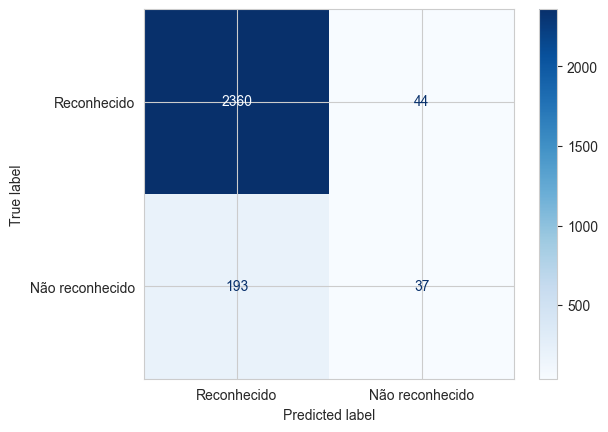

In [6]:
ConfusionMatrixDisplay.from_estimator(grid_search_2018_2024_modelo1, X_test_2018_2024_modelo1, y_test_2018_2024_modelo1, 
                                      values_format='d', cmap='Blues', display_labels=['Reconhecido', 'Não reconhecido'])

### Resultados - com balanceamento SMOTE

In [7]:
smote = SMOTE(random_state=1)
X_train_smote_2018_2024_modelo1_, y_train_smote_2018_2024_modelo1 = smote.fit_resample(X_train_2018_2024_modelo1, y_train_2018_2024_modelo1)

pipeline_2018_2024_modelo1 = Pipeline([
    ('scaler', StandardScaler()), 
    ('logreg', LogisticRegression(random_state=1, solver='lbfgs'))  
])

# Definir hiperparâmetros para o Grid Search
param_grid_2018_2024_modelo1 = {
    'logreg__C': [0.01, 0.1, 1, 10],  
    'logreg__max_iter': [1000],  
    'logreg__fit_intercept': [True, False],
    'logreg__tol': [1e-4, 1e-3],
    'logreg__penalty': ['l1', 'l2'],
}

# Grid Search com validação cruzada
grid_search_2018_2024_modelo1 = GridSearchCV(pipeline_2018_2024_modelo1, param_grid_2018_2024_modelo1, cv=3, scoring='f1_weighted', n_jobs=-1)

# Treinar o pipeline com Grid Search
grid_search_2018_2024_modelo1.fit(X_train_smote_2018_2024_modelo1_, y_train_smote_2018_2024_modelo1)

# Melhor modelo encontrado
logreg_best_2018_2024_modelo1 = grid_search_2018_2024_modelo1.best_estimator_

print(f"Melhores hiperparâmetros: {grid_search_2018_2024_modelo1.best_params_}")

# F1 score no conjunto de teste
y_pred_2018_2024_modelo1_smote = logreg_best_2018_2024_modelo1.predict(X_test_2018_2024_modelo1)

f1_smote_2018_2024_modelo1_smote = f1_score(y_test_2018_2024_modelo1, y_pred_2018_2024_modelo1_smote, average='weighted')
print(f"F1 Score: {f1_smote_2018_2024_modelo1_smote:.6f}")

classification_report_smote_2018_2024_modelo1 = metrics.classification_report(y_test_2018_2024_modelo1, y_pred_2018_2024_modelo1_smote, digits=6, target_names=['Reconhecido', 'Não reconhecido'])
print('Classification report para modelo 1 com smote (2018 - 2024): \n')
print(classification_report_smote_2018_2024_modelo1)

Melhores hiperparâmetros: {'logreg__C': 10, 'logreg__fit_intercept': True, 'logreg__max_iter': 1000, 'logreg__penalty': 'l2', 'logreg__tol': 0.001}
F1 Score: 0.773180
Classification report para modelo 1 com smote (2018 - 2024): 

                 precision    recall  f1-score   support

    Reconhecido   0.947368  0.726290  0.822227      2404
Não reconhecido   0.168142  0.578261  0.260529       230

       accuracy                       0.713364      2634
      macro avg   0.557755  0.652275  0.541378      2634
   weighted avg   0.879327  0.713364  0.773180      2634

